# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [4]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt
!python -m pip install --upgrade ipywidgets


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: ipywidgets in /root/.local/lib/python3.7/site-packages (8.1.5)


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import DataLoader

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, transform = transform, download = True)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, transform = transform, download = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

transforms.ToTensor() converts the images from pixel into PyTorch tensors, which is required for pytorch models. It also scales pixel values into 0 and 1.

I had preprocess the data by using transforms.Normalize((0.1307,), (0.3081,)), which are the mean and standard deviation of commonly used MNIST dataset. Normalization helps the model converge faster by setting a standard mean and standard deviation value. 

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

9


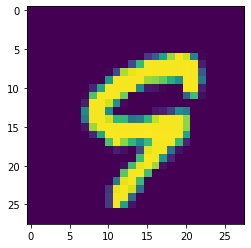

0


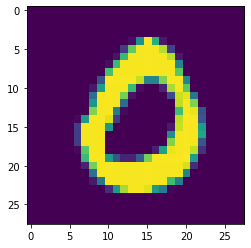

3


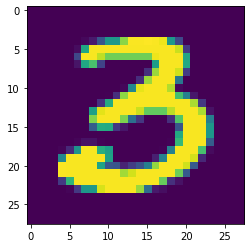

5


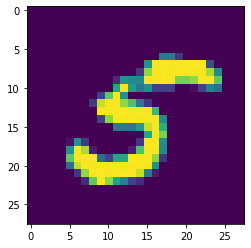

0


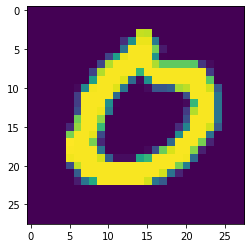

In [5]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [17]:
class MNIST_Network(nn.Module):
    def __init__(self):
        super(MNIST_Network, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(28 * 28, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.hidden3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        input = self.flatten(x)
        layer1 = F.leaky_relu(self.hidden1(input))
        layer1_drop = self.dropout(layer1)
        layer2 = F.leaky_relu(self.hidden2(layer1_drop))
        layer2_drop = self.dropout(layer2)
        output = self.hidden3(layer2)
        return output

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [18]:
model = MNIST_Network()

In [19]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if not (batch_idx + 1) % 250:
            print("Epoch " + str(epoch+1) + '/' + str(num_epochs))
            print("Loss: " + str(running_loss / 250))
            running_loss = 0.0
    train_losses.append(running_loss / len(train_loader))

print("Training complete!")

Epoch 1/5
Loss: 0.5707471666336059
Epoch 1/5
Loss: 0.2841082262992859
Epoch 1/5
Loss: 0.2392616757452488
Epoch 2/5
Loss: 0.1870427820980549
Epoch 2/5
Loss: 0.17091563515365124
Epoch 2/5
Loss: 0.15888939714431763
Epoch 3/5
Loss: 0.13405092249065637
Epoch 3/5
Loss: 0.1325779831185937
Epoch 3/5
Loss: 0.1280531424060464
Epoch 4/5
Loss: 0.11214226254075765
Epoch 4/5
Loss: 0.11263424257561565
Epoch 4/5
Loss: 0.11896965727955103
Epoch 5/5
Loss: 0.10399045566469431
Epoch 5/5
Loss: 0.11077677906304598
Epoch 5/5
Loss: 0.10221089314669371
Training complete!


Plot the training loss (and validation loss/accuracy, if recorded).

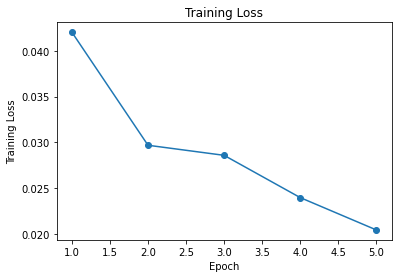

In [21]:
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [22]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total * 100
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 97.40%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [23]:
## YOUR CODE HERE ##
## changed -> F.relu to F.leakyrelu
## added: dropout

## Saving your model
Using `torch.save`, save your model for future loading.

In [24]:
model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to mnist_model.pth
